In [ ]:
import os
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import scipy
import copy
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
import torchvision
import torch.utils.data
from matplotlib import pyplot as plt
from tqdm import tqdm
from drive.MyDrive.Colab_Notebooks.Diffuse_553.ddpm_553.utils import *
from drive.MyDrive.Colab_Notebooks.Diffuse_553.ddpm_553.UNet import UNet, UNet_conditional, EMA
import logging
from torch.utils.tensorboard import SummaryWriter
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if os.path.exists('./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553'):
  print("1")

1


In [ ]:
!pip install pytorch_fid
from pytorch_fid import fid_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_known_args()[0]
args.run_name = "DDPM_conditional_sin"
args.epochs = 200
args.batch_size = 128
args.image_size = 32
args.num_classes = 10
args.dataset_path = "./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets"
#args.subset_path = "./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/cifar10_subset_images"
args.device = "cuda"
args.lr = 3e-4
args.loss_type = 'mse'  # 'mse' or 'l1'

In [ ]:
# get cifar_10 data
def get_data_cifar10(args):
    transforms = torchvision.transforms.Compose([
        #torchvision.transforms.Resize(40),  # args.image_size + 1/4 *args.image_size
        #torchvision.transforms.RandomResizedCrop(args.image_size, scale=(0.8, 1.0)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    #dataset = torchvision.datasets.ImageFolder(args.dataset_path, transform=transforms)
    dataset_un = torchvision.datasets.CIFAR10(root= args.dataset_path,train=False, transform=transforms, download=False)
    dataloader = DataLoader(dataset_un, batch_size=args.batch_size, shuffle=True)
    return dataloader, dataset_un

In [ ]:
## -------------run only for the first time !!---------------

# Create the directory for CIFAR10 subset images
os.makedirs('./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/cifar10_subset_images', exist_ok=True)

# Create the directory for CIFAR10 generated images
os.makedirs('./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/cifar10_generate_images', exist_ok=True)

# generate a subset of cifar_10
dataloader, dataset_un = get_data_cifar10(args)
n = 10000  # create subset 
cifar10_subset, _ = torch.utils.data.random_split(dataset_un, [n,len(dataset_un)-n])
cifar10_subset_dataloader_un = DataLoader(cifar10_subset, batch_size=args.batch_size, shuffle=True)

#save images to path
for i, (image, _) in enumerate(cifar10_subset):
    save_image(image,f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/cifar10_subset_images/image_{i}.png')


In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [ ]:
class Diffusion:
    def __init__(self, noise_steps=500, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self, schedule="sigmoid", s=0.008):  
        if schedule == "cosine":
          '''
            def f(t, noise_steps):
                return (np.cos((t / noise_steps + s) / (1 + s) * np.pi / 2)) ** 2
            alphas = []
            f0 = f(0, self.noise_steps)
            for t in range(self.noise_steps + 1):
                alphas.append(f(t, self.noise_steps) / f0)
            betas = []
            for t in range(1, self.noise_steps + 1):
                betas.append(min(1 - alphas[t] / alphas[t - 1], 0.999))
            return torch.tensor(betas).float()
          '''
          steps = self.noise_steps + 1
          x = torch.linspace(0, self.noise_steps, steps)
          alphas_cumprod = torch.cos(((x / self.noise_steps) + s) / (1 + s) * torch.pi * 0.5) ** 2
          alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
          betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
          return torch.clip(betas, 0.0001, 0.9999)
        elif schedule == "linear":
            scale = 1000/ self.noise_steps
            return torch.linspace(self.beta_start*scale, self.beta_end*scale, self.noise_steps)
        elif schedule == "quadratic":
            scale = 1000/ self.noise_steps
            return torch.linspace((self.beta_start*scale)**0.5, (self.beta_end*scale)**0.5, self.noise_steps) ** 2
        elif schedule == "sigmoid":
            scale = 1000/ self.noise_steps
            betas = torch.linspace(-8, 8, self.noise_steps)
            return torch.sigmoid(betas) * (self.beta_end - self.beta_start)*scale + self.beta_start*scale

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, labels, cfg_scale=3):
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

In [ ]:
dataloader, dataset_con = get_data_cifar10(args)

In [ ]:
## only run for the first time 
os.makedirs(f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/dogs', exist_ok=True)
os.makedirs(f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/trucks', exist_ok=True)

In [ ]:
if os.path.exists("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models/DDPM_conditional/condition_ckpt_cifar_ema_100.pt"):
  print("1")

1


In [ ]:
## only run for the first time
dog_id = 0
truck_id = 0
for i in range(len(dataset_con)):
    if dataset_con[i][1] == 5:
        save_image(dataset_con[i][0], f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/dogs/img_{dog_id}.png')
        dog_id += 1
    if dataset_con[i][1] == 9:
        save_image(dataset_con[i][0], f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/trucks/img_{truck_id}.png')
        truck_id += 1

In [ ]:
print('# of samples for train, {}'.format(len(dataset_con)))
print('Classes in train: {}'.format(dataset_con.classes))

# of samples for train, 10000
Classes in train: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
for j in range(20):
    os.makedirs(f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs_sin/epoch_{j}', exist_ok=True)
    os.makedirs(f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks_sin/epoch_{j}', exist_ok=True)

In [ ]:
for j in range(20):
    os.makedirs(f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs_ema_sin/epoch_{j}', exist_ok=True)
    os.makedirs(f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks_ema_sin/epoch_{j}', exist_ok=True)

In [ ]:
def train(args):
    setup_logging(args.run_name)
    device = args.device
    #model = UNet().to(device)
    model = UNet_conditional(num_classes=args.num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    if os.path.exists("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models/DDPM_conditional/condition_ckpt_cifar_ema_40.pt"):
        ckpt = torch.load("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models/DDPM_conditional/condition_ckpt_cifar_ema_40.pt")
        opt = torch.load("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models/DDPM_conditional/condition_optim_40.pt")
        model.load_state_dict(ckpt)
        optimizer.load_state_dict(opt)
    if args.loss_type == 'mse':
        unet_loss = nn.MSELoss()
    elif args.loss_type == 'l1':
        unet_loss = nn.L1loss()
    diffusion = Diffusion(img_size=args.image_size, device=device)
    logger = SummaryWriter(os.path.join("runs", args.run_name))
    l = len(dataloader)

    ema = EMA(0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False) 

    fid_dog_history = []
    fid_truck_history = []
    fid_dog_ema_history = []
    fid_truck_ema_history = []

    for epoch in range(args.epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, labels) in enumerate(pbar):
            #FIXEME
            #import pdb; pdb.set_trace()

            images = images.to(device)
            labels = labels.to(device) 
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            if np.random.random() < 0.1:
                labels = None            
            predicted_noise = model(x_t, t, labels)
            loss = unet_loss(noise, predicted_noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.step_ema(ema_model, model)
            if args.loss_type == 'mse':
                pbar.set_postfix(MSE=loss.item())
                logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)
            elif args.loss_type == 'l1': 
                pbar.set_postfix(L1=loss.item())
                logger.add_scalar("L1", loss.item(), global_step=epoch * l + i)

        #sampled_images = diffusion.sample(model, n=images.shape[0])
        #save_images(sampled_images, os.path.join("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results", args.run_name, f"{150+epoch}.jpg"))
        #torch.save(model.state_dict(), os.path.join("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models", args.run_name, f"uncondition_ckpt_large_cifar.pt"))

        if epoch % 20 == 0:
            labels1 = torch.arange(10).long().to(device)
            labels = torch.cat((labels1,labels1,labels1),dim=0).to(device)

            sampled_images = diffusion.sample(model, n=len(labels), labels=labels) # 30,3,32,32
            ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)
            print(f'epoch_{epoch}')
            plot_images(sampled_images)

            save_images(sampled_images, os.path.join("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results", args.run_name, f"{epoch}.jpg"),nrow=10)
            save_images(ema_sampled_images, os.path.join("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results", args.run_name, f"{epoch}_ema.jpg"),nrow=10)
           
        if epoch % 10 == 0:  

            ##### sample 20 dog and 20 truck images to compute fid score
            dog_labels = 5*torch.ones(20).long().to(device)
            truck_labels = 9*torch.ones(20).long().to(device)
            dog_truck_labels = torch.cat((dog_labels,truck_labels),dim=0).to(device)

            sampled_images_dog_truck = diffusion.sample(model, n=len(dog_truck_labels), labels=dog_truck_labels) # 30,3,32,32
            ema_sampled_images_dog_truck = diffusion.sample(ema_model, n=len(dog_truck_labels), labels=dog_truck_labels)

            for i in range(len(dog_truck_labels)//2):
                # Ensure that the pixel values are in the range [0, 1]
                sampled_image_dog = sampled_images_dog_truck[i].float()/255.0
                sampled_image_truck = sampled_images_dog_truck[i+20].float()/255.0
                save_image(sampled_image_dog, f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs_sin/epoch_{epoch//10}/img_{i}.png')
                save_image(sampled_image_truck, f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks_sin/epoch_{epoch//10}/img_{i}.png')

                ema_sampled_image_dog = ema_sampled_images_dog_truck[i].float()/255.0
                ema_sampled_image_truck = ema_sampled_images_dog_truck[i+20].float()/255.0
                save_image(ema_sampled_image_dog, f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs_ema_sin/epoch_{epoch//10}/img_{i}.png')
                save_image(ema_sampled_image_truck, f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks_ema_sin/epoch_{epoch//10}/img_{i}.png')
            
            ### compute fid

            cifar10_dogset_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/dogs'
            dog_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs_sin/epoch_{epoch//10}'
            fid_dog = fid_score.calculate_fid_given_paths([cifar10_dogset_path, dog_images_path], 20, 'cuda',2048)
            fid_dog_history.append(fid_dog)

            cifar10_truckset_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/trucks'
            truck_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks_sin/epoch_{epoch//10}'
            fid_truck = fid_score.calculate_fid_given_paths([cifar10_truckset_path, truck_images_path], 20, 'cuda',2048)
            fid_truck_history.append(fid_truck)

            ema_dog_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs_ema_sin/epoch_{epoch//10}'
            fid_dog_ema = fid_score.calculate_fid_given_paths([cifar10_dogset_path, ema_dog_images_path], 20, 'cuda',2048)
            fid_dog_ema_history.append(fid_dog_ema)

            ema_truck_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks_ema_sin/epoch_{epoch//10}'
            fid_truck_ema = fid_score.calculate_fid_given_paths([cifar10_truckset_path, ema_truck_images_path], 20, 'cuda',2048)
            fid_truck_ema_history.append(fid_truck_ema)

            torch.save(model.state_dict(), os.path.join("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models", args.run_name, f"condition_ckpt_cifar_{epoch}.pt"))
            torch.save(ema_model.state_dict(), os.path.join("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models", args.run_name, f"condition_ckpt_cifar_ema_{epoch}.pt"))
            torch.save(optimizer.state_dict(), os.path.join("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models", args.run_name, f"condition_optim_{epoch}.pt"))

In [ ]:
fid_dog_history = []
fid_truck_history = []
fid_dog_ema_history = []
fid_truck_ema_history = []

for epoch in range(args.epochs):
    if epoch % 10 == 0:
        cifar10_dogset_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/dogs'
        dog_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs_sin/epoch_{epoch//10}'
        fid_dog = fid_score.calculate_fid_given_paths([cifar10_dogset_path, dog_images_path], 20, 'cuda',2048)
        fid_dog_history.append(fid_dog)

        dog_images_ema_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs_ema_sin/epoch_{epoch//10}'
        fid_dog_ema = fid_score.calculate_fid_given_paths([cifar10_dogset_path, dog_images_ema_path], 20, 'cuda',2048)
        fid_dog_ema_history.append(fid_dog_ema)       

        cifar10_truckset_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/trucks'
        truck_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks_sin/epoch_{epoch//10}'
        fid_truck = fid_score.calculate_fid_given_paths([cifar10_truckset_path, truck_images_path], 20, 'cuda',2048)
        fid_truck_history.append(fid_truck)

        trucks_images_ema_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/trucks_ema_sin/epoch_{epoch//10}'
        fid_truck_ema = fid_score.calculate_fid_given_paths([cifar10_dogset_path, dog_images_ema_path], 20, 'cuda',2048)
        fid_truck_ema_history.append(fid_truck_ema)


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


In [ ]:
fid_dog_history

[465.89319347112155,
 408.27935934491734,
 257.6537999640734,
 420.043624124103,
 409.1315112973908,
 374.85886983289026,
 486.6514384488681,
 441.16833787167803,
 348.58113517514573,
 433.47219676861823,
 454.87079119431326,
 359.3239526412915,
 463.0681532876346,
 279.9575072114267,
 318.2303119344839,
 418.59345029286766,
 308.1701980103535,
 424.821365338885,
 276.87621290180596,
 299.9322725583699]

In [ ]:
fid_truck_history

[470.59719915103807,
 336.90866460821445,
 300.4761181167042,
 470.22490091768714,
 336.8022151365075,
 234.49493332587383,
 425.56418295896697,
 349.77627894183576,
 191.595320090125,
 245.83668502459966,
 328.91875769497483,
 285.06045673893846,
 376.2525672769236,
 250.63328257100827,
 302.91498677780567,
 362.94596486517764,
 260.89874125462825,
 339.5036428321295,
 229.59761902402948,
 212.19044781718083]

In [ ]:
fid_dog_ema_history

[413.2749072489886,
 426.1532911147238,
 274.1080382400414,
 291.145429058844,
 279.8587983468359,
 257.18378883757305,
 295.6992573893698,
 266.9447383994563,
 256.42726068598483,
 291.3485374396912,
 269.8689314566646,
 279.70166670480614,
 303.5154838154601,
 275.9862142612525,
 304.6497130071565,
 272.0341049036284,
 290.1964168927502,
 285.6389283266168,
 263.1626567411279,
 276.2268941907272]

In [ ]:
fid_truck_ema_history

[413.2749072489886,
 426.1532911147238,
 274.1080382400414,
 291.145429058844,
 279.8587983468359,
 257.18378883757305,
 295.6992573893698,
 266.9447383994563,
 256.42726068598483,
 291.3485374396912,
 269.8689314566646,
 279.70166670480614,
 303.5154838154601,
 275.9862142612525,
 304.6497130071565,
 272.0341049036284,
 290.1964168927502,
 285.6389283266168,
 263.1626567411279,
 276.2268941907272]

In [ ]:
x = torch.arange(20)*10
x

tensor([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
        140, 150, 160, 170, 180, 190])

Text(0.5, 1.0, 'FID score of generated truck images using CFG and sigmoid schedule ')

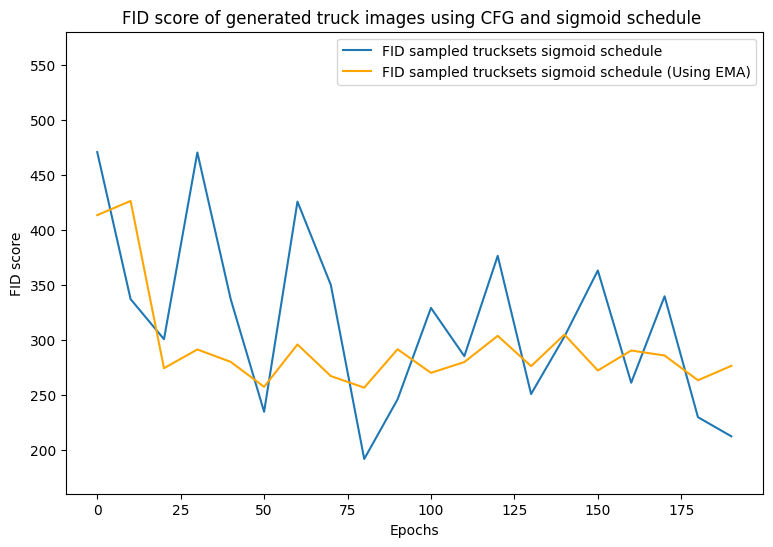

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(x, fid_truck_history, label = "FID sampled trucksets sigmoid schedule")
plt.legend(loc='best')
plt.plot(x, fid_truck_ema_history, color="orange", label = "FID sampled trucksets sigmoid schedule (Using EMA)")
plt.legend(loc='best')
plt.ylim([160,580])
plt.xlabel("Epochs")
plt.ylabel("FID score")
plt.title("FID score of generated truck images using CFG and sigmoid schedule ")

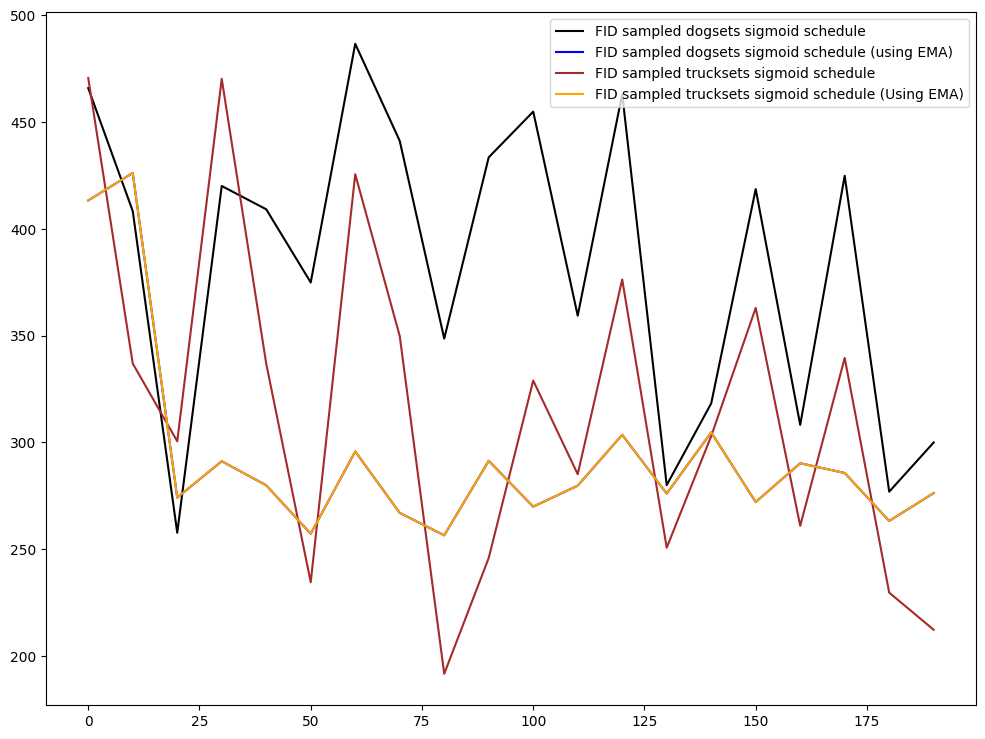

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(x, fid_dog_history, color="black", label = "FID sampled dogsets sigmoid schedule")
plt.legend(loc='best')
plt.plot(x, fid_dog_ema_history, color="blue", label = "FID sampled dogsets sigmoid schedule (using EMA)")
plt.legend(loc='best')
plt.plot(x, fid_truck_history, color="brown", label = "FID sampled trucksets sigmoid schedule")
plt.legend(loc='best')
plt.plot(x, fid_truck_ema_history, color="orange", label = "FID sampled trucksets sigmoid schedule (Using EMA)")
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("FID score")
plt.title("FID score of two classes generated images using CFG and sigmoid schedule")

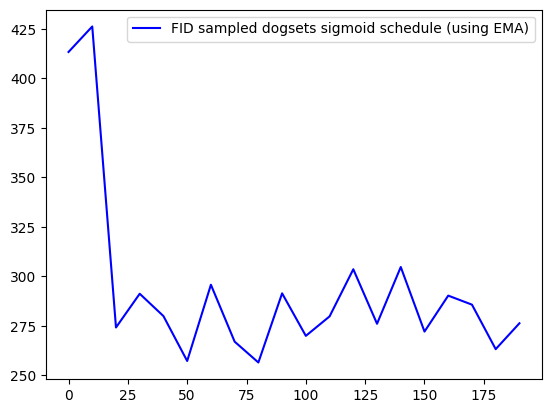

In [ ]:
plt.plot(x, fid_dog_ema_history, color="blue", label = "FID sampled dogsets sigmoid schedule (using EMA)")
plt.legend(loc='best')

In [ ]:
if os.path.exists("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models/DDPM_conditional/condition_ckpt_cifar_8.pt"):
  print("1")

1


100%|██████████| 79/79 [00:30<00:00,  2.61it/s, MSE=0.0847]
499it [00:32, 15.46it/s]
499it [00:31, 15.61it/s]


epoch_0


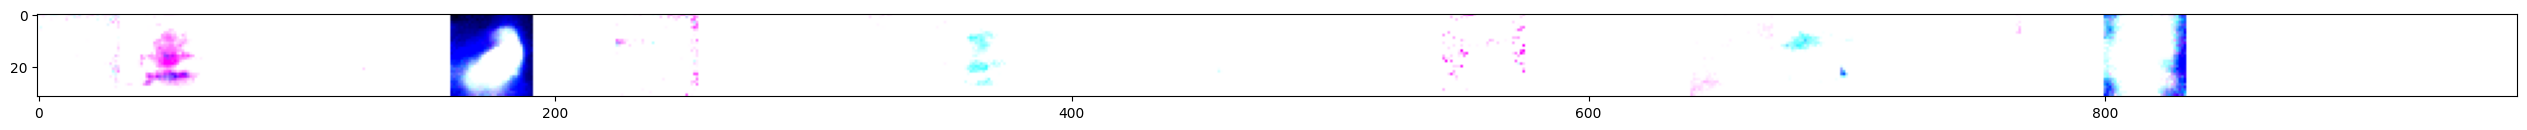

499it [00:40, 12.19it/s]
499it [00:40, 12.17it/s]
100%|██████████| 79/79 [00:30<00:00,  2.61it/s, MSE=0.0711]
499it [00:40, 12.18it/s]
499it [00:40, 12.19it/s]
100%|██████████| 79/79 [00:30<00:00,  2.62it/s, MSE=0.0748]
499it [00:32, 15.46it/s]
499it [00:32, 15.48it/s]


epoch_20


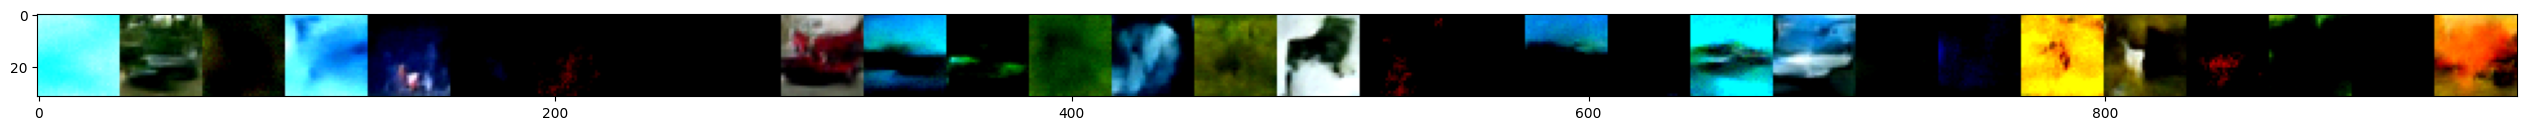

499it [00:41, 12.17it/s]
499it [00:41, 12.16it/s]
100%|██████████| 79/79 [00:30<00:00,  2.59it/s, MSE=0.0915]
499it [00:40, 12.17it/s]
499it [00:40, 12.20it/s]
100%|██████████| 79/79 [00:30<00:00,  2.59it/s, MSE=0.0826]
499it [00:32, 15.51it/s]
499it [00:32, 15.51it/s]


epoch_40


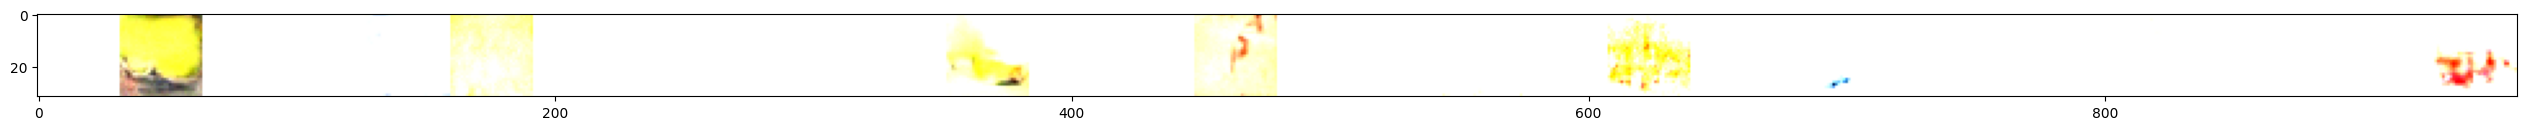

499it [00:41, 12.14it/s]
499it [00:40, 12.19it/s]
100%|██████████| 79/79 [00:30<00:00,  2.60it/s, MSE=0.0968]
499it [00:40, 12.18it/s]
499it [00:40, 12.19it/s]
100%|██████████| 79/79 [00:30<00:00,  2.60it/s, MSE=0.0792]
499it [00:31, 15.61it/s]
499it [00:32, 15.50it/s]


epoch_60


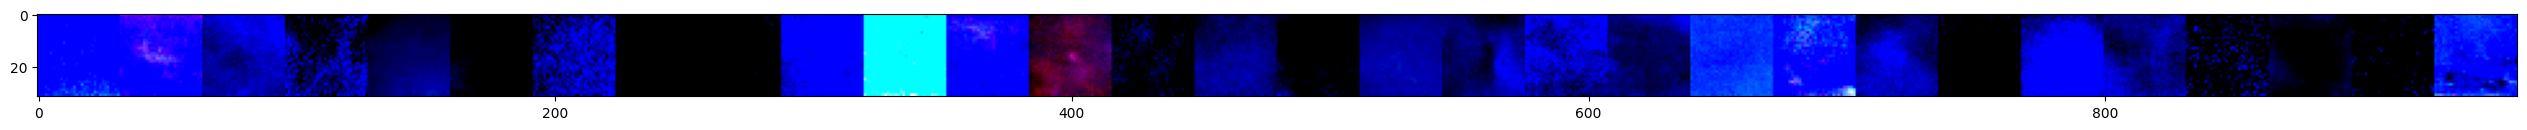

499it [00:40, 12.19it/s]
499it [00:40, 12.20it/s]
100%|██████████| 79/79 [00:30<00:00,  2.58it/s, MSE=0.0973]
499it [00:40, 12.18it/s]
499it [00:40, 12.18it/s]
100%|██████████| 79/79 [00:30<00:00,  2.58it/s, MSE=0.0861]
499it [00:32, 15.55it/s]
499it [00:32, 15.52it/s]


epoch_80


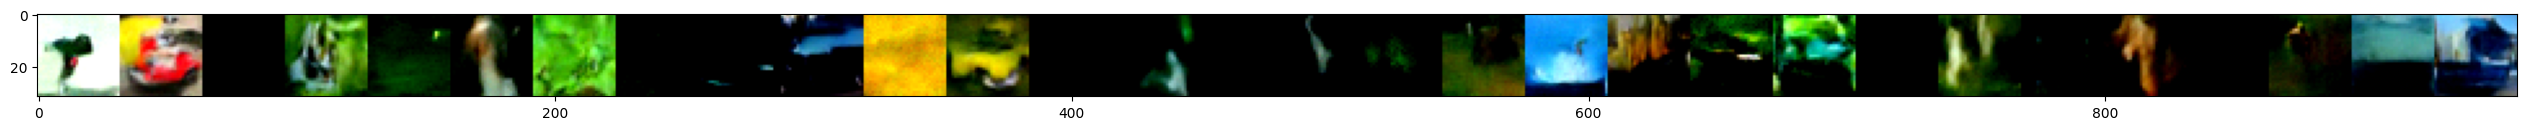

499it [00:41, 12.16it/s]
499it [00:41, 12.17it/s]
100%|██████████| 79/79 [00:30<00:00,  2.56it/s, MSE=0.0461]
499it [00:41, 12.13it/s]
499it [00:41, 12.13it/s]
100%|██████████| 79/79 [00:30<00:00,  2.58it/s, MSE=0.0708]
499it [00:32, 15.48it/s]
499it [00:32, 15.36it/s]


epoch_100


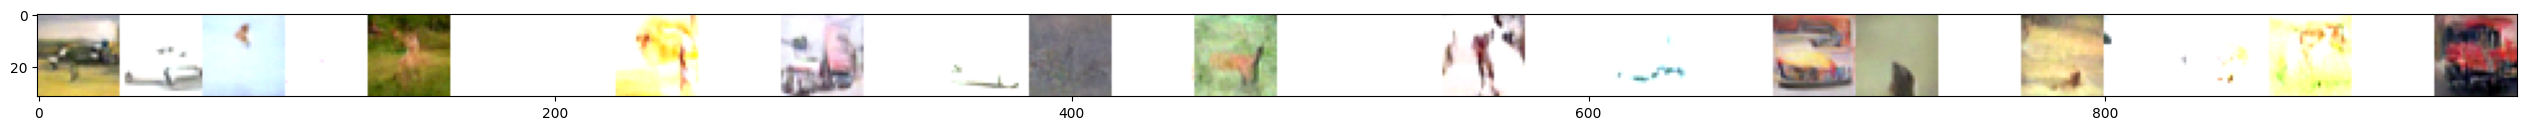

499it [00:41, 12.14it/s]
499it [00:41, 12.15it/s]
100%|██████████| 79/79 [00:30<00:00,  2.56it/s, MSE=0.0604]
499it [00:41, 12.17it/s]
499it [00:41, 12.16it/s]
100%|██████████| 79/79 [00:30<00:00,  2.56it/s, MSE=0.0759]
499it [00:32, 15.37it/s]
499it [00:32, 15.45it/s]


epoch_120


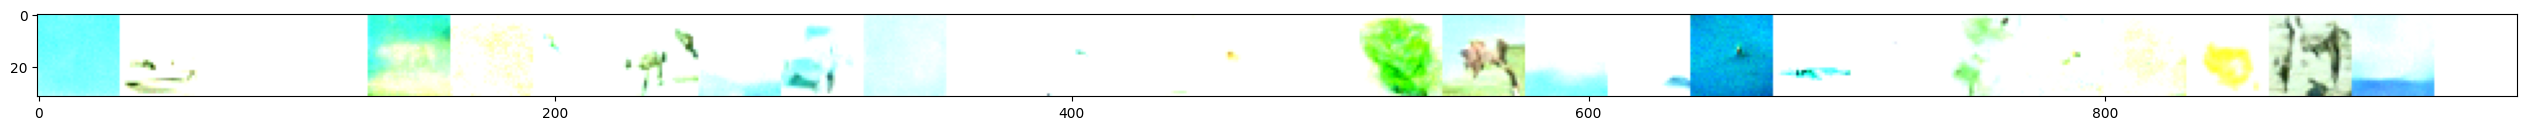

499it [00:41, 12.16it/s]
499it [00:41, 12.13it/s]
100%|██████████| 79/79 [00:30<00:00,  2.57it/s, MSE=0.0825]
499it [00:41, 12.13it/s]
499it [00:41, 12.14it/s]
100%|██████████| 79/79 [00:30<00:00,  2.56it/s, MSE=0.0517]
499it [00:32, 15.41it/s]
499it [00:32, 15.50it/s]


epoch_140


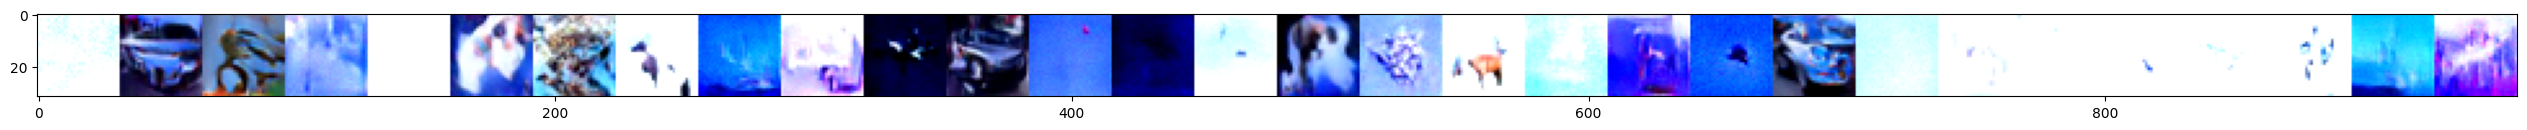

499it [00:41, 12.14it/s]
499it [00:41, 12.16it/s]
100%|██████████| 79/79 [00:31<00:00,  2.54it/s, MSE=0.0492]
499it [00:41, 12.17it/s]
499it [00:41, 12.14it/s]
100%|██████████| 79/79 [00:30<00:00,  2.55it/s, MSE=0.0807]
499it [00:32, 15.43it/s]
499it [00:32, 15.35it/s]


epoch_160


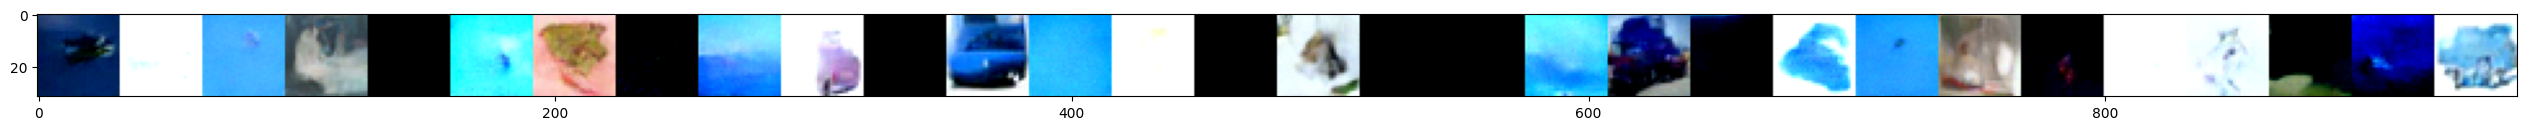

499it [00:41, 12.12it/s]
499it [00:41, 12.16it/s]
100%|██████████| 79/79 [00:30<00:00,  2.55it/s, MSE=0.0757]
499it [00:41, 12.13it/s]
499it [00:41, 12.12it/s]
100%|██████████| 79/79 [00:31<00:00,  2.53it/s, MSE=0.0655]
499it [00:32, 15.26it/s]
499it [00:32, 15.29it/s]


epoch_180


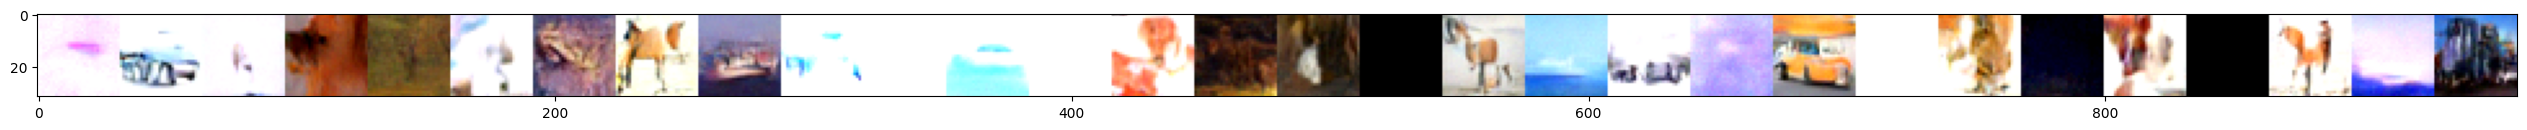

499it [00:41, 12.10it/s]
499it [00:41, 12.08it/s]
100%|██████████| 79/79 [00:31<00:00,  2.53it/s, MSE=0.0482]
499it [00:41, 12.07it/s]
499it [00:41, 12.08it/s]
100%|██████████| 79/79 [00:31<00:00,  2.54it/s, MSE=0.123]


In [ ]:
if __name__ == '__main__':
    train(args)

In [ ]:
fid_dog_history

NameError: ignored

In [ ]:
fid_truck_history

NameError: ignored

In [ ]:
fid_dog_ema

NameError: ignored

In [ ]:
fid_truck_ema_history

In [ ]:
!nvidia-smi

Sun Apr 16 05:43:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |  11945MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
sample_number = 400
device = "cuda"
model = UNet().to(device)
ckpt = torch.load("./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/models/DDPM_Uncondtional/uncondition_ckpt_large_cifar.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=32, device=device)
sampled_images = diffusion.sample(model, sample_number)
print(sampled_images.shape)    
#plt.figure(figsize=(16, 16))
#plt.imshow(torch.cat([torch.cat([i for i in sampled_images.cpu()], dim=-1)], dim=-2).permute(1, 2, 0).cpu())
#plt.show()

999it [06:48,  2.45it/s]

torch.Size([400, 3, 32, 32])


In [ ]:
cifar10_dogset_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/dogs'
            dog_images_path = f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/results/dogs/epoch_{epoch//10}'
            fid_dog = fid_score.calculate_fid_given_paths([cifar10_dogset_path, dog_images_path], 20, 'cuda',2048)

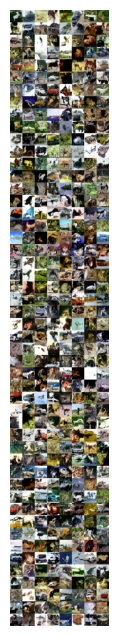

In [ ]:
# Define the number of rows and columns for the plot
num_rows = sample_number//8
num_cols = 8

# Split the generated images into rows
image_rows = [sampled_images[i:i+num_cols] for i in range(0, len(sampled_images), num_cols)]

# Concatenate the images within each row horizontally
concatenated_rows = [torch.cat(tuple(image_row), dim=-1) for image_row in image_rows]

# Concatenate the rows vertically
concatenated_image = torch.cat(tuple(concatenated_rows), dim=-2)

# Plot the concatenated image
plt.figure(figsize=(10, 8))
plt.imshow(concatenated_image.permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()



In [ ]:
from pytorch_fid import fid_score

cifar10_subset_path = './drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/cifar10_subset_images'
generated_images_path = './drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/cifar10_generate_images'

# Save the generated images to disk 
for i in range(sample_number):
    # Ensure that the pixel values are in the range [0, 1]
    sampled_image = sampled_images[i].float()/255.0
    save_image(sampled_image, f'./drive/MyDrive/Colab_Notebooks/Diffuse_553/ddpm_553/datasets/cifar10_generate_images/image_{i}.png')


In [ ]:
fid = fid_score.calculate_fid_given_paths([cifar10_subset_path, generated_images_path], 128, 'cuda',2048)
print('FID score:', fid)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 226MB/s]
100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


FID score: 126.84604960264954
